In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

print(torch.__version__)

2.4.1


# Reading weather data


In [8]:
df = pd.read_csv("data/furth-data.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40920 entries, 0 to 40919
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         40920 non-null  object 
 1   temperature  40920 non-null  float64
 2   humidity     40920 non-null  int64  
 3   rain         40920 non-null  float64
 4   pressure     40920 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.6+ MB
None


,time,temperature,humidity,rain,pressure
0,2020-01-01T00:00,-2.6,93,0.0,1037.0
1,2020-01-01T01:00,-2.7,93,0.0,1037.1
2,2020-01-01T02:00,-3.0,94,0.0,1036.7
3,2020-01-01T03:00,-3.6,94,0.0,1036.4
4,2020-01-01T04:00,-3.5,94,0.0,1036.4


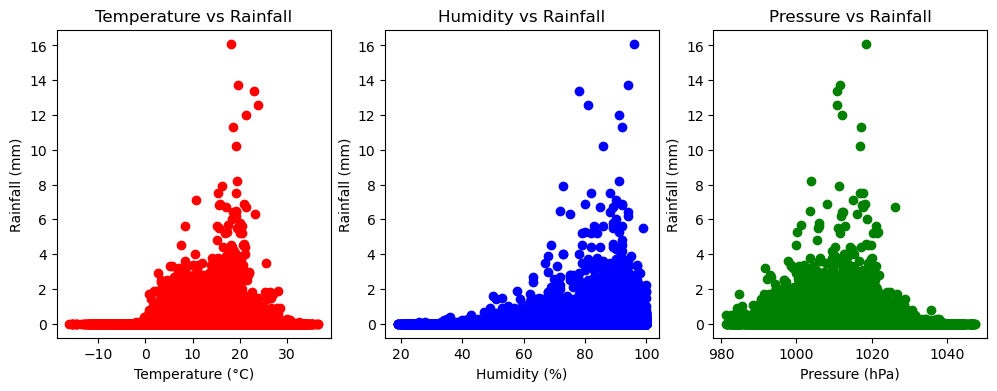

In [9]:
# visualise data
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(df["temperature"], df["rain"], c="red")
ax[0].set_xlabel("Temperature (°C)")
ax[0].set_ylabel("Rainfall (mm)")
ax[0].set_title("Temperature vs Rainfall")
# add ax for humidity
ax[1].scatter(df["humidity"], df["rain"], c="blue")
ax[1].set_xlabel("Humidity (%)")
ax[1].set_ylabel("Rainfall (mm)")
ax[1].set_title("Humidity vs Rainfall")
# add ax for pressure
ax[2].scatter(df["pressure"], df["rain"], c="green")
ax[2].set_xlabel("Pressure (hPa)")
ax[2].set_ylabel("Rainfall (mm)")
ax[2].set_title("Pressure vs Rainfall")
plt.show()


# Creating features and labels



In [10]:
X = df.drop(["rain", "time"], axis=1)
y = (df["rain"] > 0).astype(int)

In [11]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1) # .unsqueeze(1) to make it a column vector

print("X_tensor shape: ", X_tensor.shape)
print("y_tensor shape: ", y_tensor.shape)

X_tensor shape:  torch.Size([40920, 3])
y_tensor shape:  torch.Size([40920, 1])


## Splitting data into training and testing sets


In [12]:
RANDOM_SEED = 42 # setting random seed to ensure reproducibility
torch.manual_seed(RANDOM_SEED)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Then split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  torch.Size([26188, 3])
y_train shape:  torch.Size([26188, 1])
X_val shape:  torch.Size([6548, 3])
y_val shape:  torch.Size([6548, 1])
X_test shape:  torch.Size([8184, 3])
y_test shape:  torch.Size([8184, 1])


In [13]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Fit on training data and transform
# X_train_scaled = scaler.fit_transform(X_train.numpy())

# # Transform validation and test data
# X_val_scaled = scaler.transform(X_val.numpy())
# X_test_scaled = scaler.transform(X_test.numpy())

# # Convert back to tensors
# X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
# X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Now you can use these scaled tensors in your DataLoader and model

In [14]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
class WeatherDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

data_batch = next(iter(train_loader))
features, labels = data_batch

# features.shape, labels.shape
features[:10], labels[:10]

(tensor([[-7.0000e-01,  8.6000e+01,  1.0279e+03],
         [ 8.2000e+00,  9.1000e+01,  9.9740e+02],
         [ 1.7100e+01,  8.2000e+01,  1.0220e+03],
         [ 1.2600e+01,  7.7000e+01,  1.0237e+03],
         [ 1.5500e+01,  4.7000e+01,  1.0147e+03],
         [ 6.2000e+00,  5.2000e+01,  1.0182e+03],
         [ 2.1000e+01,  4.8000e+01,  1.0254e+03],
         [ 2.2000e+01,  4.2000e+01,  1.0163e+03],
         [ 2.1100e+01,  6.8000e+01,  1.0235e+03],
         [ 2.5500e+01,  5.3000e+01,  1.0203e+03]]),
 tensor([[0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.]]))

In [16]:

class RainPredictor(nn.Module):
    def __init__(self):
        super(RainPredictor, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.batch_norm2 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.dropout(self.relu(self.batch_norm1(self.fc1(x))))
        x = self.dropout(self.relu(self.batch_norm2(self.fc2(x))))
        x = self.fc3(x)
        return x

model = RainPredictor().to(device)


In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)


# Add learning rate scheduler
# ReduceLROnPlateau reduces the learning rate when the validation loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Training loop


In [18]:
num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        y_logits = model(features)
        loss = loss_fn(y_logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        y_preds = torch.round(torch.sigmoid(y_logits))
        train_acc += accuracy_fn(y_preds, labels)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.inference_mode():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            y_logits = model(features)
            loss = loss_fn(y_logits, labels)
            val_loss += loss.item()
            y_preds = torch.round(torch.sigmoid(y_logits))
            val_acc += accuracy_fn(y_preds, labels)
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {current_lr}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

print('Training finished.')

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.inference_mode():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        y_logits = model(features)
        loss = loss_fn(y_logits, labels)
        test_loss += loss.item()
        y_preds = torch.round(torch.sigmoid(y_logits))
        test_acc += accuracy_fn(y_preds, labels)

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch [10/100], Train Loss: 0.3915, Train Acc: 82.92%, Val Loss: 0.5174, Val Acc: 74.23%, LR: 0.01
Epoch [20/100], Train Loss: 0.3893, Train Acc: 82.74%, Val Loss: 0.3944, Val Acc: 82.97%, LR: 0.005
Epoch [30/100], Train Loss: 0.3870, Train Acc: 82.94%, Val Loss: 0.3776, Val Acc: 83.48%, LR: 0.005
Epoch [40/100], Train Loss: 0.3860, Train Acc: 83.23%, Val Loss: 0.3768, Val Acc: 83.32%, LR: 0.0025
Epoch [50/100], Train Loss: 0.3866, Train Acc: 83.15%, Val Loss: 0.3771, Val Acc: 83.47%, LR: 0.0025
Early stopping at epoch 57
Training finished.
Test Loss: 0.3773, Test Acc: 83.37%


# Visualise loss and accuracy over epochs

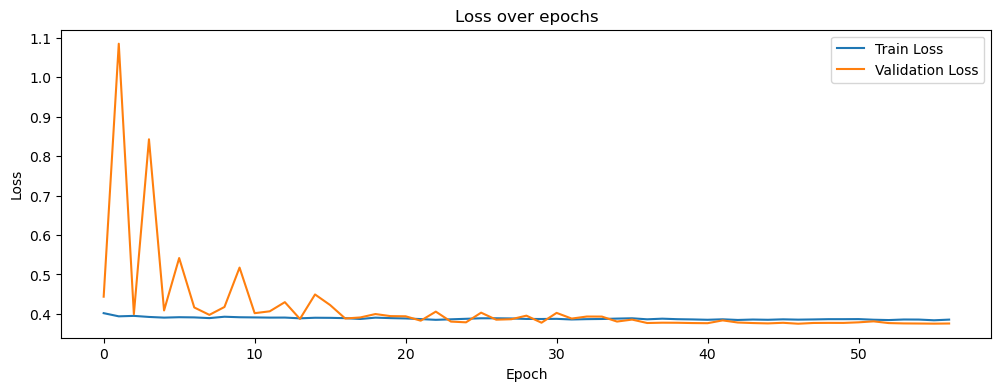

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_loss_history, label='Train Loss')
ax.plot(val_loss_history, label='Validation Loss')
ax.set_title('Loss over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()



In [30]:
# model = RainPredictor()
# model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
# model.eval()

# test = torch.tensor([17.4, 83, 1009]).unsqueeze(dim=0).to(device)
# pick random row from test dataset
test = test_dataset[torch.randint(0, len(test_dataset), (1,))]
X, y = test
X = X.to(device)
y = y.to(device)
print(X, y)
# Apply scaling
# test_scaled = scaler.transform(test.cpu().numpy())
# # Convert back to tensor and move to device
# test = torch.tensor(test_scaled, dtype=torch.float32).to(device)

with torch.inference_mode():
    output = model(X)
    prob = torch.sigmoid(output)
    pred = torch.round(prob)


print("Probability:", prob.item())
print("Prediction:", pred.item(), "Actual:", y.item())


tensor([[  16.4000,   94.0000, 1017.9000]]) tensor([[1.]])
Probability: 0.29948392510414124
Prediction: 0.0 Actual: 1.0


In [22]:
model = RainPredictor()
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
model.eval()

# input tensor is variable on the first dimension
input_tensor = torch.randn(1, 3)
torch.onnx.export(model, input_tensor, "rain_predictor.onnx", verbose=True, input_names=["input"], output_names=["output"], dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

# check onnx model
import onnx

onnx_model = onnx.load("rain_predictor.onnx")
onnx.checker.check_model(onnx_model)
# print(onnx.helper.printable_graph(model.graph))
print("Model is correct!")



Exported graph: graph(%input : Float(*, 3, strides=[3, 1], requires_grad=0, device=cpu),
      %fc1.weight : Float(32, 3, strides=[3, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(16, 32, strides=[32, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %fc3.weight : Float(1, 16, strides=[16, 1], requires_grad=1, device=cpu),
      %fc3.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %batch_norm1.weight : Float(32, strides=[1], requires_grad=1, device=cpu),
      %batch_norm1.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %batch_norm1.running_mean : Float(32, strides=[1], requires_grad=0, device=cpu),
      %batch_norm1.running_var : Float(32, strides=[1], requires_grad=0, device=cpu),
      %batch_norm2.weight : Float(16, strides=[1], requires_grad=1, device=cpu),
      %batch_norm2.bias : Float(16, strides=[

In [23]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("rain_predictor.onnx")

outputs = ort_session.run(
    None,
    {"input": np.array([[-2.0000,   85.0000, 1001.5000], [ 16.8000,  71.0000, 980.1000], [  6.5000,  98.0000, 974.1000]], dtype=np.float32)},
)
print(outputs[0])
# remove torch calls
print(1 / (1 + np.exp(-outputs[0])))

[[-3.3481176 ]
 [ 0.12282503]
 [ 1.796509  ]]
[[0.03395686]
 [0.53066766]
 [0.8577234 ]]
